# Digit Recognizer for Pros

[Digit Recognizer](https://www.kaggle.com/c/digit-recognizer) is a `Kaggle` competition where using the dataset you have to create a `classifier` that can classify handwritten images into digits.

Here `no pre-trained CNN or predefined architecture` is used, this is a `custom` CNN architecture.

**While doing this we'll go through**
- Data augmentation using `ImageDataGenerator`
- Building `custom` CNN architecture
- Visualizing CNN (`filters` and `feature maps`)

In [1]:
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Lambda, MaxPooling2D, Dropout, BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
# Loading the dataset
train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_df  = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [3]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


![](https://media.giphy.com/media/3o7TKUM3IgJBX2as9O/giphy.gif)

## 🏋️‍♀️ Data preprocessing

Looking at `labels` count

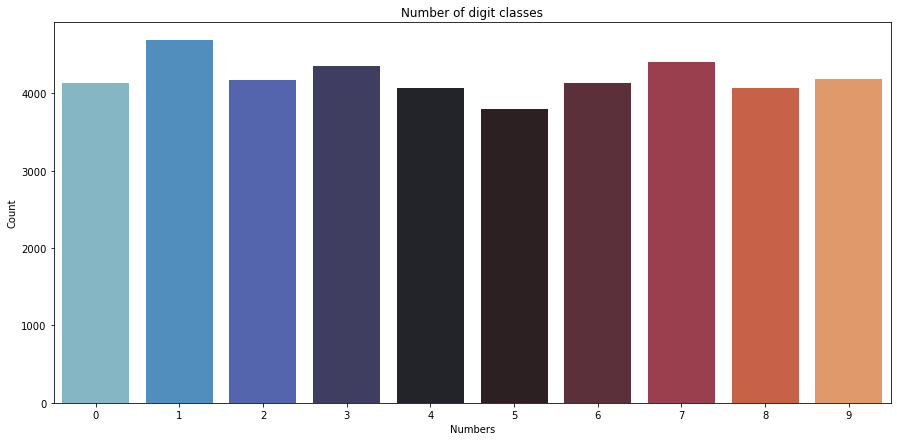

In [5]:
plt.figure(figsize=(15,7))
plt.title('Number of digit classes')
g = sns.countplot(train_df.label,palette='icefire')
g.set(xlabel='Numbers', ylabel='Count')
plt.show()

In [6]:
# Shuffling the training dataframe
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [7]:
cols = list(train_df.columns)
cols.remove('label')

x = train_df[cols]
y = train_df['label']

# Splitting the dataset into training and validation(dev) sets
x_train, x_dev, y_train, y_dev = train_test_split(x, y, test_size=0.1, random_state=0)

In [8]:
# Testing dataset (this is the set on which we'll do predictions and then submit it)
x_test = test_df[cols]

In [9]:
print(f'Training set size: {len(x_train)}')
print(f'Validation set size: {len(x_dev)}')

Training set size: 37800
Validation set size: 4200


In [10]:
print(x_train.shape)
print(x_train.values.reshape(-1, 28, 28).shape)

(37800, 784)
(37800, 28, 28)


In [11]:
# Reshaping the datasets to feed images of 28X28 pixels to our neural network
# And also scaling the images
x_train = x_train.values.reshape(-1, 28, 28) / 255
x_dev   = x_dev.values.reshape(-1, 28, 28) / 255
x_test  = x_test.values.reshape(-1, 28, 28) / 255

In [12]:
print(x_train.shape)
print(np.expand_dims(x_train, axis=-1).shape)

(37800, 28, 28)
(37800, 28, 28, 1)


In [13]:
# Adding an additional dimension of channel (1 as images are grayscale)
x_train = np.expand_dims(x_train, axis=-1)
x_dev   = np.expand_dims(x_dev, axis=-1)
x_test  = np.expand_dims(x_test, axis=-1)

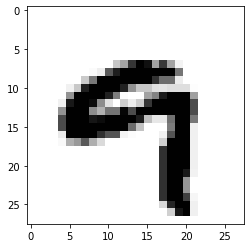

In [14]:
plt.imshow(x_train[0].reshape((28, 28)), cmap=plt.cm.binary)

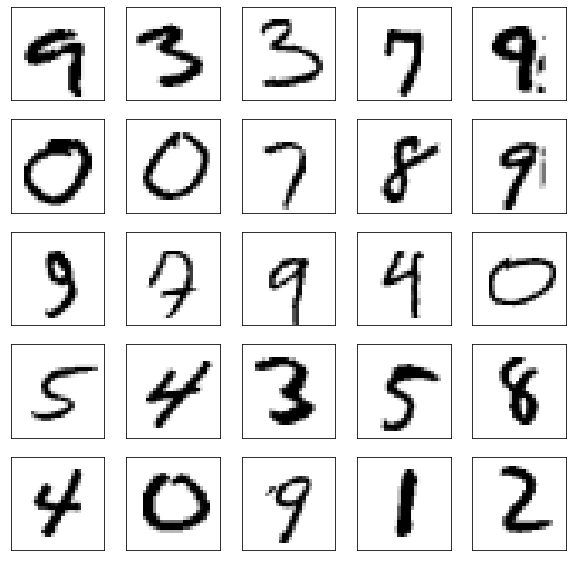

In [15]:
# Looking at first 25 training examples

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    
    # reshaping the images as (28, 28, 1) is an invalid shape to plot imgs
    plt.imshow(x_train[i].reshape((28, 28)), cmap=plt.cm.binary)
    
plt.show()

### 👨‍👨‍👦‍👦 Data Augmentation

![](https://media.giphy.com/media/fzZzoftMBR8is/giphy.gif)

In [16]:
def data_augmentation(x_data, y_data, batch_size):
    datagen = ImageDataGenerator(
        featurewise_center=False,            # set input mean to 0 over the dataset
        samplewise_center=False,             # set each sample mean to 0
        featurewise_std_normalization=False, # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,                 # apply ZCA whitening
        rotation_range=10,                   # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                    # Randomly zoom image 
        width_shift_range=0.1,               # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,              # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,               # randomly flip images
        vertical_flip=False,                 # randomly flip images
    )
    
    
    datagen.fit(x_data)
    train_data = datagen.flow(x_data, y_data, batch_size=batch_size, shuffle=True)
    
    return train_data

In [17]:
BATCH_SIZE = 64
aug_train_data = data_augmentation(x_train, y_train, BATCH_SIZE)

## 🧠 Modelling

In [18]:
def build_model():
    # Neural Network Architecture
    layers = [
        Conv2D(filters=96, kernel_size=(11, 11), strides=2, activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu'),
        Flatten(),
        Dense(9216, activation='relu'),
        Dense(4096, activation='relu'),
        Dense(4096, activation='relu'),
        Dense(10, activation='softmax')
    ]

    model = Sequential(layers)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 9, 9, 96)          11712     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 256)         614656    
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 9216)              37757952  
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              37752832  
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              1

In [19]:
callbacks = [
    ReduceLROnPlateau(monitor="loss",factor=0.1, patience=2, min_lr=0.000001, verbose=1),
]

In [20]:
history = model.fit(
    aug_train_data, 
    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
    batch_size=BATCH_SIZE,
    validation_data=(x_dev, y_dev), 
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
590/590 [==============================] - 14s 23ms/step - loss: 0.4049 - accuracy: 0.8682 - val_loss: 0.1130 - val_accuracy: 0.9645 - lr: 1.0000e-04
Epoch 2/50
590/590 [==============================] - 14s 24ms/step - loss: 0.1213 - accuracy: 0.9619 - val_loss: 0.0750 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 3/50
590/590 [==============================] - 13s 23ms/step - loss: 0.0922 - accuracy: 0.9714 - val_loss: 0.0584 - val_accuracy: 0.9819 - lr: 1.0000e-04
Epoch 4/50
590/590 [==============================] - 14s 24ms/step - loss: 0.0744 - accuracy: 0.9770 - val_loss: 0.0468 - val_accuracy: 0.9862 - lr: 1.0000e-04
Epoch 5/50
590/590 [==============================] - 14s 23ms/step - loss: 0.0682 - accuracy: 0.9797 - val_loss: 0.0448 - val_accuracy: 0.9886 - lr: 1.0000e-04
Epoch 6/50
590/590 [==============================] - 14s 24ms/step - loss: 0.0590 - accuracy: 0.9811 - val_loss: 0.0497 - val_accuracy: 0.9864 - lr: 1.0000e-04
Epoch 7/50
590/590 [==============

### 🪂 Plotting model's performance

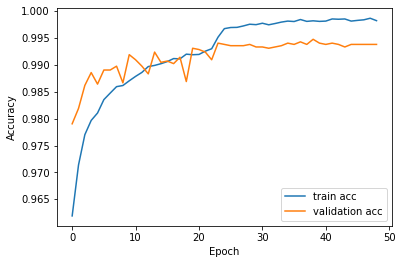

In [21]:
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'][1:], label='validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

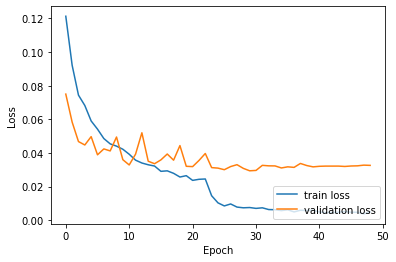

In [22]:
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'][1:], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

### Visualizing CNN

To know more read the following posts: [post_1](https://www.analyticsvidhya.com/blog/2018/03/essentials-of-deep-learning-visualizing-convolutional-neural-networks/), [post_2](https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/) and [post_3](https://www.kaggle.com/arpitjain007/guide-to-visualize-filters-and-feature-maps-in-cnn).

To `visualize how CNN and Max pooling works` go through the following [kernel](https://www.kaggle.com/akashsdas/how-does-convolutions-work).



**Visualize filters**

Plotting the `96th` filter of the `1st conv layer`.

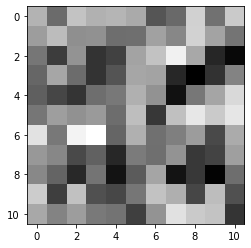

In [23]:
top_layer = model.layers[0]
plt.imshow(top_layer.get_weights()[0][:, :, :, 95].squeeze(), cmap='gray')

In [24]:
print(f'Shape of 1st conv layer weights: {model.layers[0].get_weights()[0].shape}')
print(f'Shape of 2nd conv layer weights: {model.layers[2].get_weights()[0].shape}')

Shape of 1st conv layer weights: (11, 11, 1, 96)
Shape of 2nd conv layer weights: (5, 5, 96, 256)


In [25]:
def plot_filters_for_conv_layer(model, layer_index, num_columns=5, cmap='binary', how_many='all'):
    layer = model.layers[layer_index]
    filter_weights = layer.get_weights()[0]
    
    num_filters = layer.filters if how_many == 'all' else how_many
    num_rows = (num_filters // num_columns) + (num_filters % num_columns)
    # example:
    # num_rows = (96 // 5) + (96 % 5) == 20 (to plot all the filters)
    
    f, axs = plt.subplots(num_rows, num_columns, figsize=(20, 5 * num_rows))
    row_count = 0  # to plot num_columns figs in an individual row
    
    if not isinstance(axs, np.ndarray):
        # When num_cloumns == how_many
        axs = np.array(axs)  # to make axs iterable
        # list can also be inplace np.array but since plt.subplots axs output is of type np.ndarray I kept 
        
    for idx, row_ax in enumerate(axs):
        # plotting filters in a row
        for i, ax in enumerate(row_ax):
            if row_count + i >= num_filters:
                break
                
            if len(filter_weights.shape) == 4:
                if filter_weights.shape[2] == 1:
                    # For plotting filters whose weight shape is == (kernel_size_x, kernel_size_y, 1, #filters)
                    # example: (11, 11, 1, 96)
                    ax.imshow(filter_weights[:, :, :, row_count + i].squeeze(), cmap=cmap)
                else:
                    # For plotting filters whose weight shape is == (kernel_size_x, kernel_size_y, num > 1, #filters)
                    # example: (5, 5, 96, 256)
                    # because if ax.imshow(filter_weights[:, :, :, row_count + i].squeeze(), cmap=cmap)
                    # is used then we'll have array of (5, 5, 96) which is invalid image data for plotting 2D image
                    # (in above case where `filter_weights.shape[2] == 1` there we'll end up with (11, 11, 1) which
                    # after applying the `squeeze` function will be (11, 11) which is valid image data) so in 
                    # that case we'll just plot (5, 5) plot in the first 3D array i.e. (5, 5, 0, row_count + i) 
                    # => this is what we'll plot. To plot (5, 5, row_count + i, 0) just change indexing from
                    # [:, :, 0, row_count + i] to [:, :, row_count + i, 0]
                    ax.imshow(filter_weights[:, :, 0, row_count + i].squeeze(), cmap=cmap)
                    
                # For generalization this can be used, but to understand why 0 need to be used,
                # using the above way
                # ax.imshow(filter_weights[:, :, 0, row_count + i].squeeze(), cmap=cmap)
            else:
                break
                            
        # increasing row_count by num_columns
        row_count += num_columns 

Using `cmap` as `sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)` instead of `binary`, just to make the plot look `beautiful as you`. Also there are `96` filters in the `1st conv` layer so only plotting the first `20` filters.

Visualizing `only first 20` filters in the `1nd conv layer`. Here `sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)` is used as `cmap`.

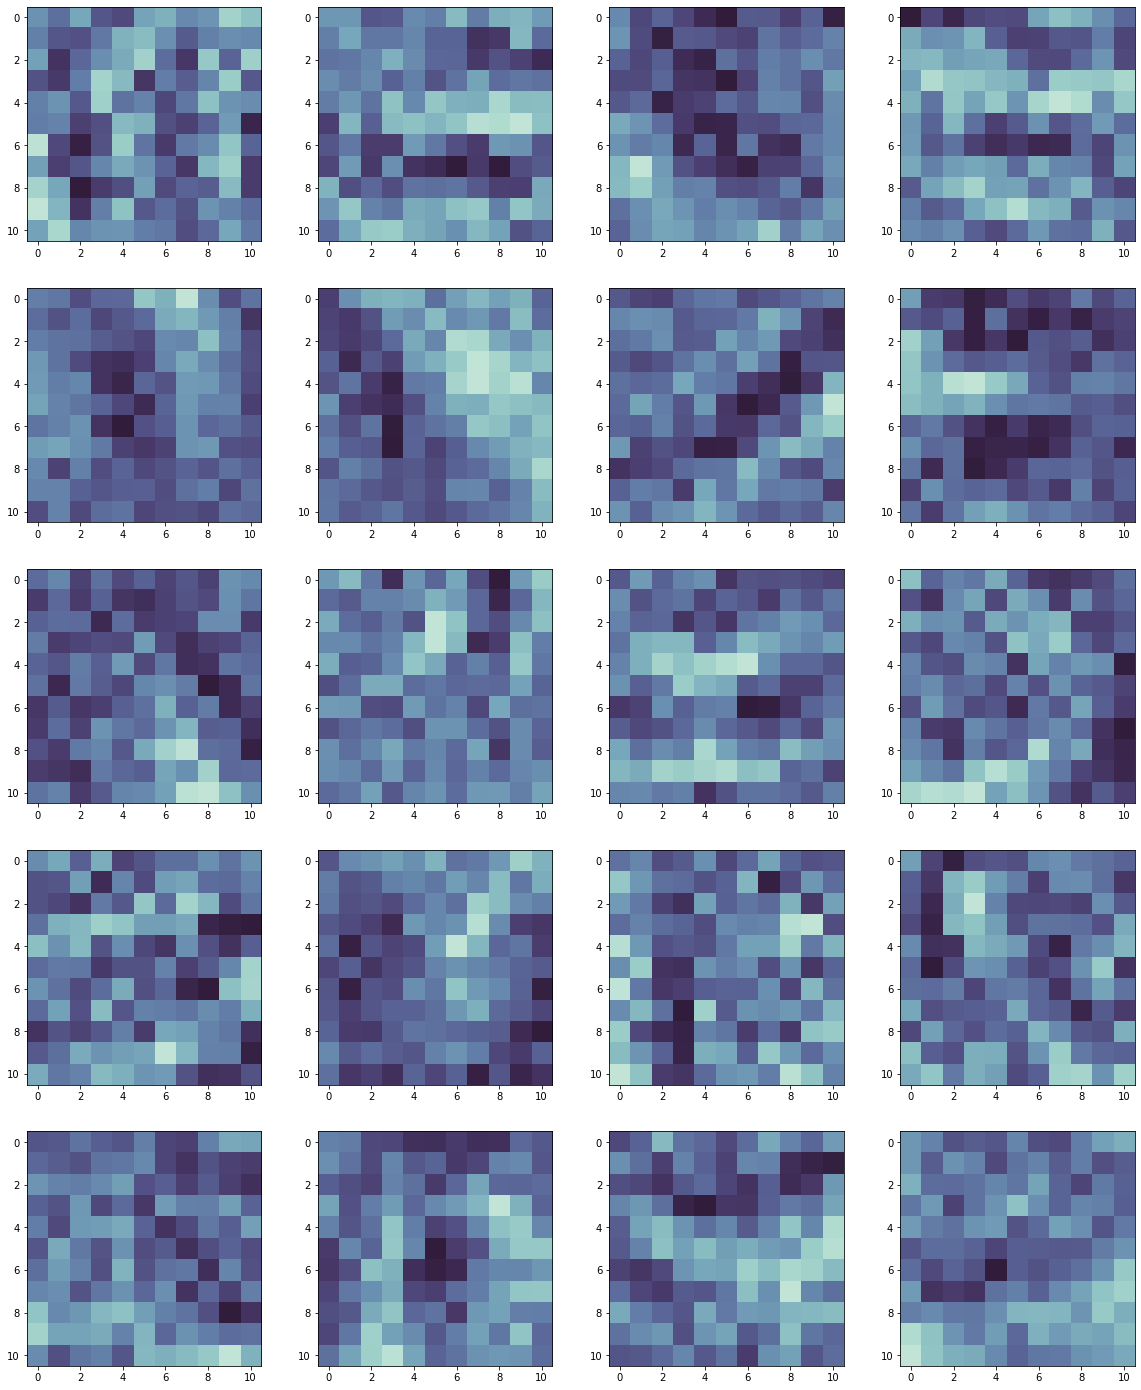

In [26]:
plot_filters_for_conv_layer(
    model, 
    0, 
    num_columns=4,
    cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True), 
    how_many=20
)  

# 11X11 filters

Visualizing `only first 10` filters in the `2nd conv layer`. Here `binary` is used as `cmap`.

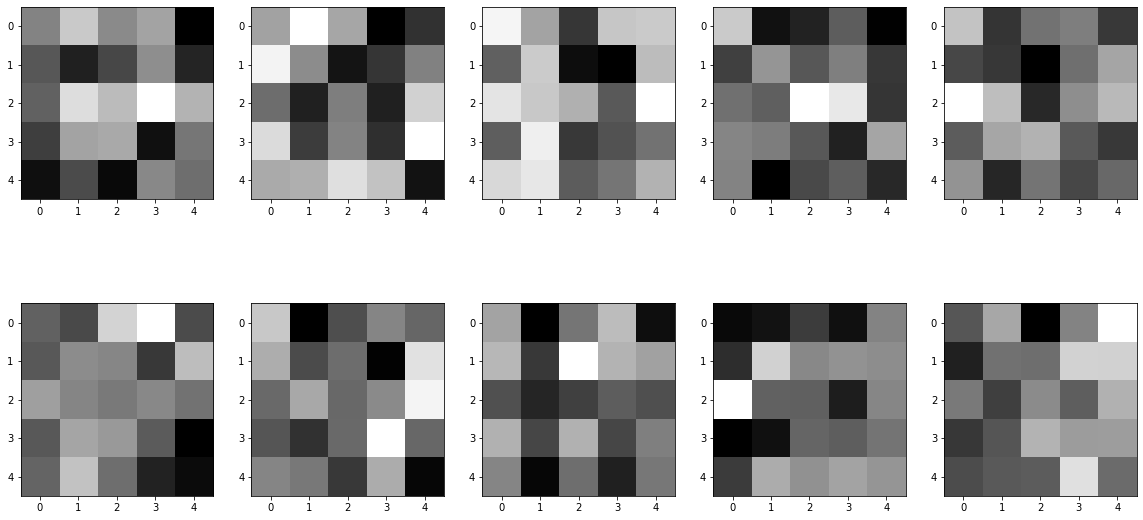

In [27]:
plot_filters_for_conv_layer(
    model, 
    2, 
    num_columns=5,
    how_many=10
)  

# 5X5 filters

**Visualizing feature maps**

In [28]:
[idx for idx in range(len(model.layers)) if 'conv' in model.layers[idx].name]

[0, 2]

The `feature maps` of a `CNN` capture the result of `applying the filters` to an input image i.e at each layer, the feature map is the output of that layer. The reason for visualising a feature map for a specific input image is to try to gain some understanding of what features our CNN detects.

In [29]:
def plot_feature_maps_for_single_conv_layer(model, layer_id, input_img, num_columns=10, cmap='binary'):
    ref_model = Model(inputs=model.inputs, outputs=model.layers[layer_id].output)
    feature_map = ref_model.predict(input_img)
    
    num_filters = feature_map[0].shape[2]
    num_rows = (num_filters // num_columns) + (num_filters % num_columns)

    fig = plt.figure(figsize=(16, 2 * num_rows))
    ix = 1
    for _ in range(num_rows):
        for _ in range(num_columns):
            if ix == num_filters:
                break
        
            # specify subplot and turn of axis
            ax = plt.subplot(num_rows, num_columns, ix)
            ax.set_xticks([])
            ax.set_yticks([])
        
            # plot filter channel in grayscale
            plt.imshow(feature_map[0, :, :, ix-1], cmap=cmap)
            ix += 1
            
    # show the figure
    plt.show()

Let's visualize `feature maps` for `7th` image in `x_train`.

In [30]:
visualize_feature_maps_for = 7

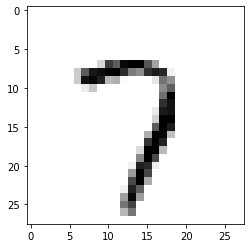

In [31]:
plt.imshow(x_train[visualize_feature_maps_for].reshape((28, 28)), cmap=plt.cm.binary)

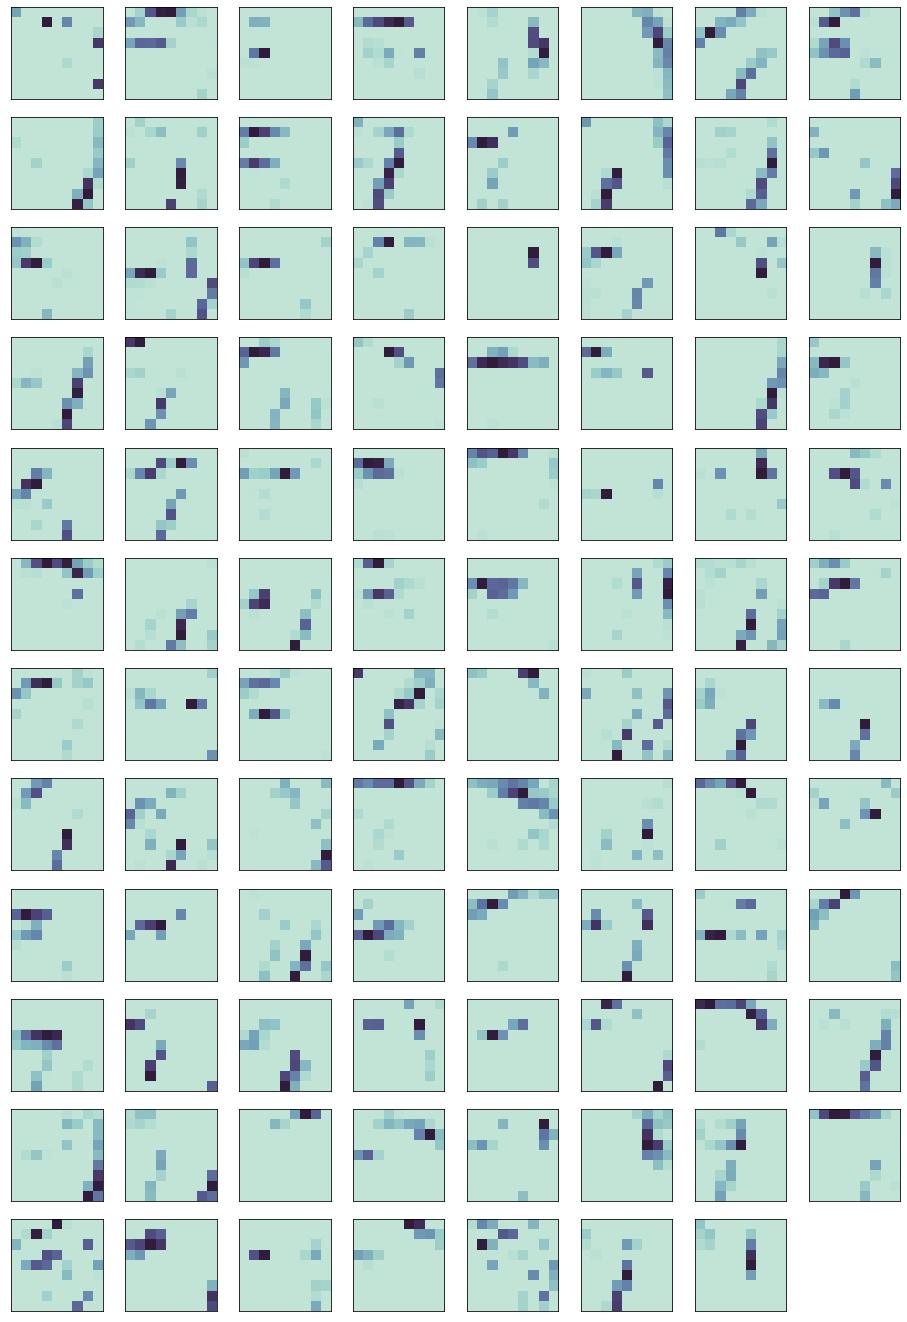

In [32]:
plot_feature_maps_for_single_conv_layer(
    model, 
    0, 
    x_train[visualize_feature_maps_for][np.newaxis, ...], 
    num_columns=8,
    cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
)

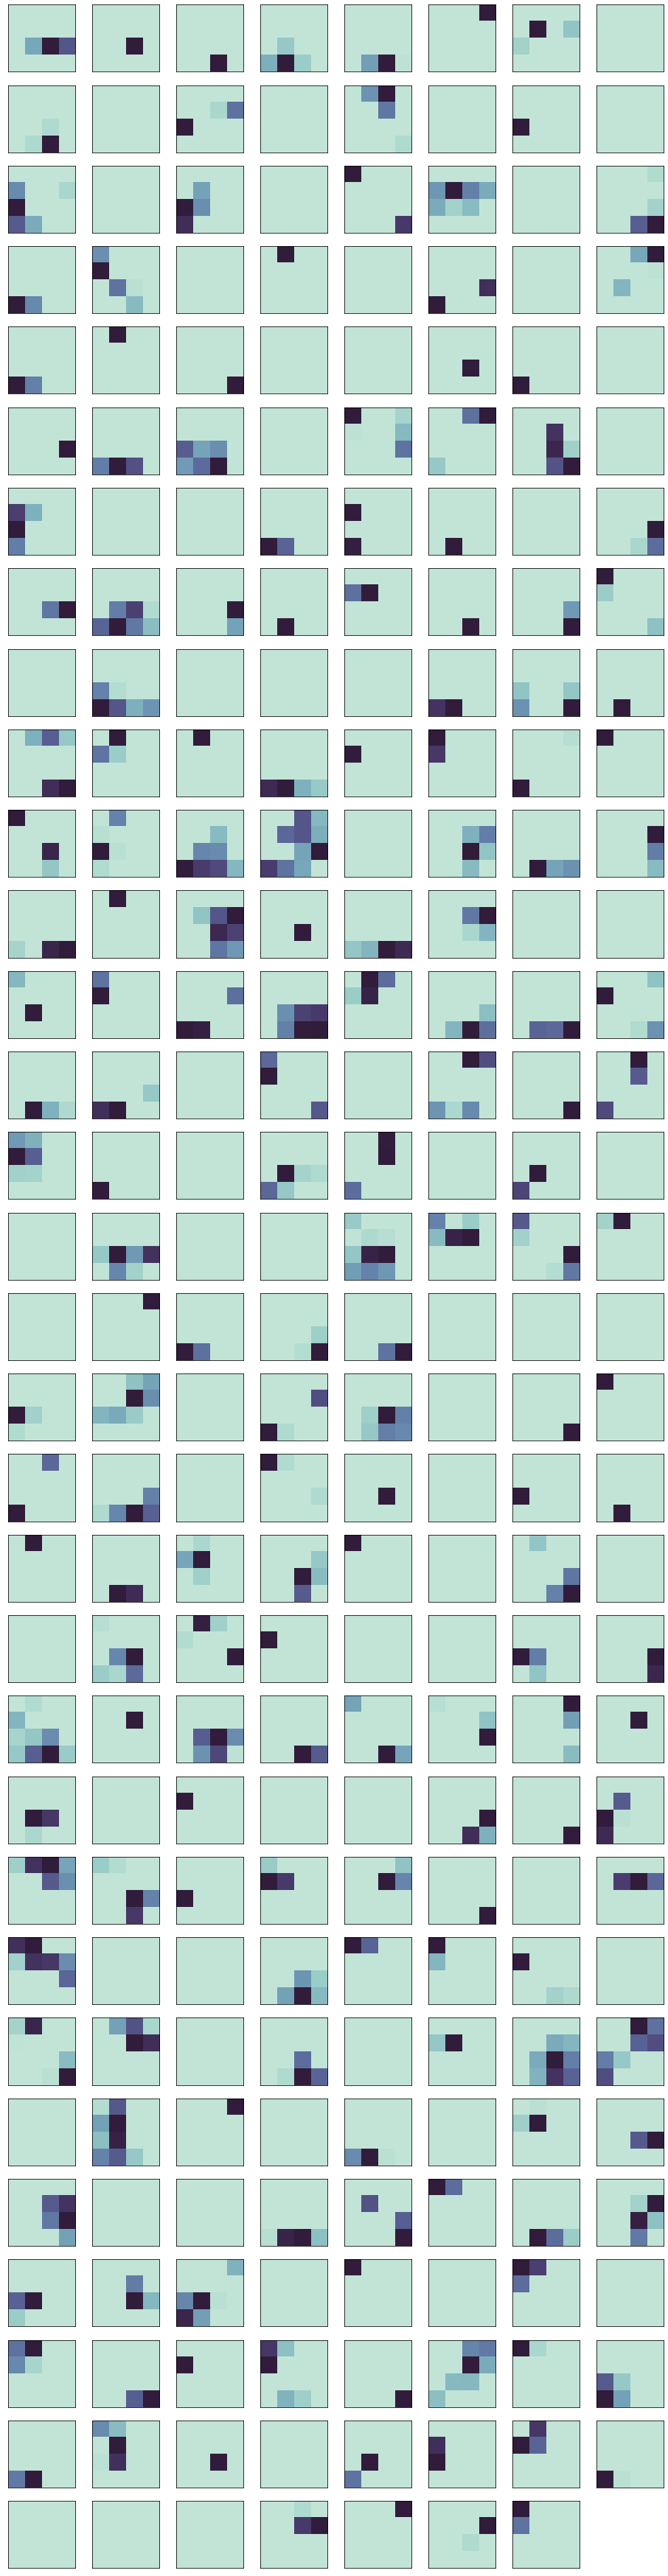

In [33]:
plot_feature_maps_for_single_conv_layer(
    model, 
    2, 
    x_train[visualize_feature_maps_for][np.newaxis, ...],
    num_columns=8,
    cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
)

## 🔮 Evaluation

Here model is evaluated on the `validation` dataset.

`plot_confusion_matrix` function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`.

In [34]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    plt.figure(figsize=(8, 8))
    
    plt.imshow(cm, interpolation='nearest', cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

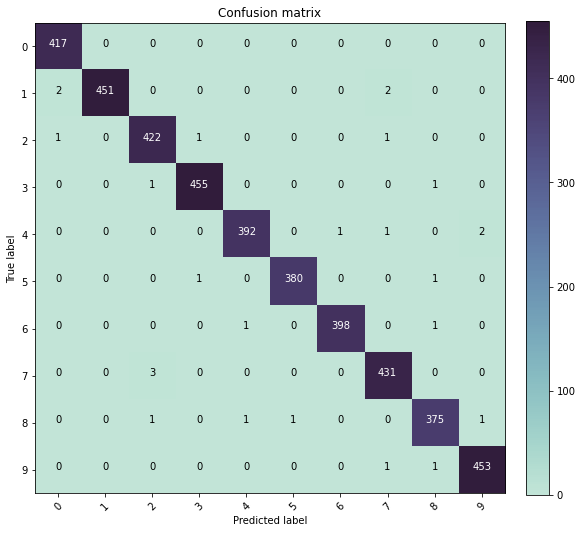

In [35]:
# Predict labels for validation dataset
y_pred = model.predict(x_dev)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_dev, y_pred_classes) 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(10)) 

[1.0662800e-20 8.5529293e-24 2.7979746e-16 1.0998474e-18 6.6032540e-21
 2.1041348e-22 2.0474271e-21 1.5873636e-22 1.0000000e+00 2.3931704e-16]
Predicted digit is: 8
Accuracy is: 100.0%


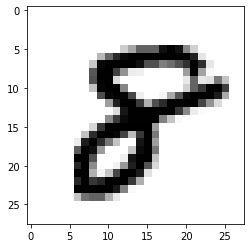

In [36]:
# Verify the results

predictions = y_pred

print(predictions[0]) # Confidence matrix

print('Predicted digit is: ' + str(np.argmax(predictions[0])))
print('Accuracy is: ' + str(np.max(predictions[0] * 100)) + '%')

# Actual Digit
plt.imshow(x_dev[0].reshape((28, 28)), cmap=plt.cm.binary)

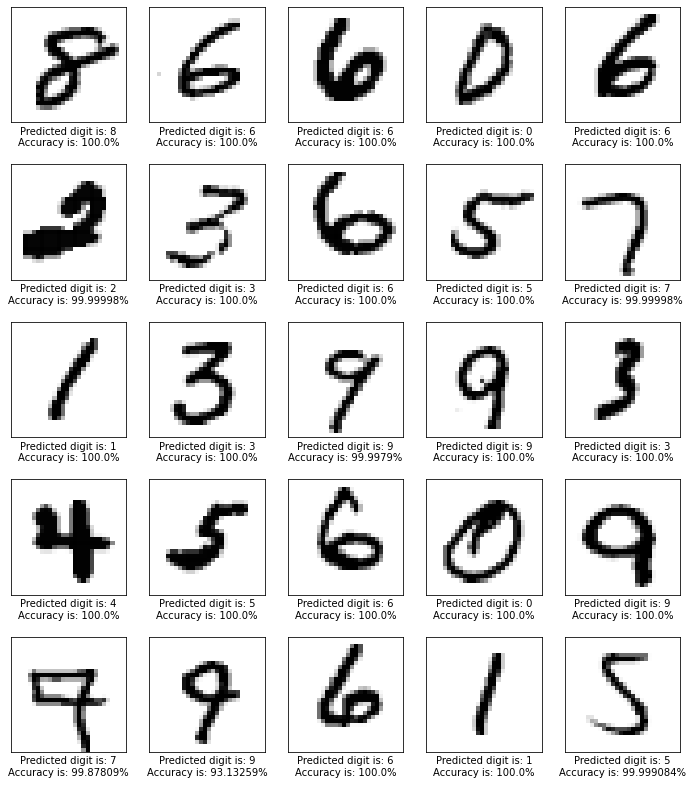

In [37]:
# Seeing first 25 validation images predictions
plt.figure(figsize=(12, 14))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_dev[i].reshape((28, 28)), cmap=plt.cm.binary)
    
    plt.xlabel(
        'Predicted digit is: ' + str(np.argmax(predictions[i])) + 
        '\n' + 
        'Accuracy is: ' + str(np.max(predictions[i] * 100)) + '%'
    )

## 🔮 Predictions on test set and 📧 submitting the results

In [38]:
predictions = model.predict(x_test)

In [39]:
submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
submission.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [40]:
for i in submission.index:
    submission['Label'][i] = np.argmax(predictions[i])

In [41]:
submission.to_csv("sample_submission.csv", index=False)

## **🎁 Saving the model**

In [42]:
model.save('model')

---

I'll wrap things up there. If you want to find some other answers then go ahead `edit` this kernel. If you have any `questions` then do let me know.

If this kernel helped you then don't forget to 🔼 `upvote` and share your 🎙 `feedback` on improvements of the kernel.

![](https://media.giphy.com/media/xjZtu4qi1biIo/giphy.gif)

---